In [1]:
import numpy as np
from dynamic_coding_analysis.analysis_pipeline import get_data
from dynamic_coding_analysis.analysis_pipeline import process_spikes as spk
import matplotlib.pyplot as plt
from matplotlib import gridspec
from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter1d
from scipy import stats
from tqdm import trange

C:\Users\ilow1\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# define sessions
base = 'G:/My Drive/Giocomo Lab/RandomForage/'
data_folder = base + 'aggregate_data/'
save_folder = base + 'Dynamic MEC Coding Project/fig1_images_supp/'

''' run analysis on sessions with >10 MEC neurons '''
mice = ['Milan', 'Pisa', 'Hanover', 'Boston', 'Camden', 'Calais', # cue poor 1a,b,c; 2a,b,c; 3a (mother of 2s)
        'Seattle', 'Portland', 'Juneau', 'Quebec', 'Toronto', 'Vancouver', # cue rich 6a,b,c; 7a,b,c
        'Mumbai', 'Kerala', 'Goa', 'Punjab', 'Salvador', # cue rich 9a, b, c, d (males); 10a
        'Seoul', 'Degu', 'Busan', 'Inchon', 'Ulsan'] # two tracks 4a,b,c; 5a,b (males)

sessions = [['0420_2', '0424_1'], # Milan
            ['0430_1', '0501_1', '0502_1'], # Pisa
            ['0615_2', '0617_5'], # Hanover
            ['0617_1', '0619_2'], # Boston
            ['0711_2'], # Camden
            ['0713_2'], # Calais
            ['1005_1', '1006_1', '1007_1', '1009_1', '1010_1'], # Seattle
            ['1005_2'], # Portland
            ['1102_1', '1104_1', '1105_1', '1106_1'], # Juneau
            ['1007_1', '1009_1'], # Quebec
            ['1111_1', '1112_1', '1113_1', '1114_1', '1115_1', '1117_1'], # Tortonto
            ['1114_1', '1115_1', '1118_1'], # Vancouver
            ['1129_1', '1130_1', '1201_1'], # Mumbai
            ['1207_1', '1208_1', '1209_1', '1210_2', '1211_1', '1213_1'], # Kerala
            ['1207_1', '1209_1', '1210_1', '1211_1'], # Goa
            ['1214_1', '1215_1', '1216_1', '1217_1', '1218_1', '1219_1'], # Punjab
            ['1202_1', '1203_1', '1204_1'], # Salvador
            ['0720', '0721'], # Seoul
            ['0720', '0721', '0722'], # Degu
            ['0730', '0801', '0802', '0803'], # Busan 
            ['0810', '0812', '0814'], # Inchon
            ['0802']] # Ulsan

In [3]:
# make a dict to hold data
data = {}
for session, m in zip(sessions, mice):
    data[m] = {}
    for s in session:
        data[m][s] = {}

In [4]:
'''
Assign color to each mouse - colorblind friendly:
see: https://personal.sron.nl/~pault/
cue poor:
    litter 1 (red): 'Milan', 'Pisa'
    litter 2 (orange): 'Hanover', 'Boston', 'Camden'
    litter 3 (yellow): 'Calais'
cue rich:
    litter 6 (green): 'Seattle', 'Portland', 'Juneau'
    litter 7 (blue): 'Quebec', 'Toronto', 'Vancouver'
    litter 9 (dark purple): 'Mumbai', 'Kerala', 'Goa', 'Punjab'
    litter 10 (light purple): 'Salvador'
two tracks: (YlOrBr)
    litter 4 (light gray, dark gray, black): 'Seoul', 'Degu', 'Busan'
    litter 5 (browns): 'Inchon', 'Ulsan'
'''
colors = np.asarray([[165, 23, 14, 255], [220, 5, 12, 255], # reds
          [232, 96, 28, 255], [241, 147, 45, 255], [246, 193, 65, 255], [247, 240, 86, 255], # oranges, yellow
          [78, 178, 101, 255], [144, 201, 135, 255], [202, 224, 171, 255], # greens
          [25, 101, 176, 255], [82, 137, 199, 255], [123, 175, 222, 255], # blues
          [136, 46, 114, 255], [153, 79, 136, 255], [170, 111, 158, 255], [186, 141, 180, 255], [209, 187, 215, 255], # purples
          [119, 119, 119, 255], [80, 80, 80, 255], [0, 0, 0, 255], # grays
          [114, 25, 14, 255], [66, 21, 10, 255]]) # browns
colors = colors/255
colors = list(colors)
for i, c in enumerate(colors):
    colors[i] = tuple(c)

In [5]:
# load the data
from pathlib import Path

N_cells = 0
for m, session in zip(mice, sessions):
    for i, s in enumerate(session):
        d = data[m][s]
        d['Y'] = np.load(data_folder + 'gap_corrected/' + m + '_' + s + '_MEC_FRtensor.npy')
        d['B'] = np.load(data_folder + 'gap_corrected/' + m + '_' + s + '_MEC_spikes.npy')
        d['A'] = np.load(data_folder + 'gap_corrected/' + m + '_' + s + '_behavior.npy')  
        d['cells'] = np.load(data_folder + 'gap_corrected/' + m + '_' + s + '_MEC_cellIDs.npy')
        
        # filter sessions with deleted AP/ML cells
        filt_file = data_folder + 'gap_corrected/' + m + '_' + s + '_MEC_idx.npy'
        if Path(filt_file).exists():
            print(m + '_' + s + ' corrected for mistargeting')
            cell_idx = np.load(filt_file)
            d['cells'] = d['cells'][cell_idx]
            d['Y'] = d['Y'][:, :, cell_idx]
            d['B'] = d['B'][:, cell_idx]
        
        N_cells += d['cells'].shape[0]
        print(m + '_' + s + ' n cells = ' + str(data[m][s]['cells'].shape[0]))

Milan_0420_2 n cells = 114
Milan_0424_1 n cells = 106
Pisa_0430_1 n cells = 227
Pisa_0501_1 n cells = 122
Pisa_0502_1 n cells = 294
Hanover_0615_2 n cells = 72
Hanover_0617_5 corrected for mistargeting
Hanover_0617_5 n cells = 152
Boston_0617_1 n cells = 83
Boston_0619_2 n cells = 92
Camden_0711_2 n cells = 78
Calais_0713_2 corrected for mistargeting
Calais_0713_2 n cells = 46
Seattle_1005_1 n cells = 207
Seattle_1006_1 n cells = 196
Seattle_1007_1 n cells = 96
Seattle_1009_1 n cells = 383
Seattle_1010_1 n cells = 142
Portland_1005_2 n cells = 149
Juneau_1102_1 n cells = 353
Juneau_1104_1 n cells = 120
Juneau_1105_1 n cells = 187
Juneau_1106_1 n cells = 152
Quebec_1007_1 n cells = 199
Quebec_1009_1 n cells = 139
Toronto_1111_1 n cells = 184
Toronto_1112_1 corrected for mistargeting
Toronto_1112_1 n cells = 74
Toronto_1113_1 n cells = 139
Toronto_1114_1 n cells = 213
Toronto_1115_1 n cells = 244
Toronto_1117_1 n cells = 162
Vancouver_1114_1 n cells = 117
Vancouver_1115_1 n cells = 151
V

In [6]:
''' N trials '''
N_trials = []
for m, session in zip(mice, sessions):
    for s in session:
        d = data[m][s]
        N_trials.append(d['Y'].shape[0])
        
print(np.min(N_trials))
print(np.max(N_trials))
print('mean, SEM: ' + str(np.mean(N_trials)) + ', ' + str(stats.sem(N_trials)))

57
450
mean, SEM: 317.0149253731343, 9.680011357025641


In [7]:
''' training time '''
train_days = np.asarray([8, 15, 17, 17, 42, 42, 15, 
                         15, 34, 15, 49, 48, 11, 11, 
                         22, 33, 15, 28, 34, 27, 15, 23]) - 1
train_weeks = train_days/7
print('training time: '+ str(np.min(train_days)) + ' days to ' + str(np.max(train_weeks)) + ' weeks')
print('mean, sem: ' + str(np.mean(train_days)) + ', ' + str(stats.sem(train_days)))

training time: 7 days to 6.857142857142857 weeks
mean, sem: 23.363636363636363, 2.686784600882394


In [8]:
''' get coordinates for all recorded units '''
hist = np.load(data_folder + '_histology.npy').item()
# get coordinates for all cells
MEC_cell_coords = np.asarray([])
for m, session in zip(mice, sessions):
    for s in session:
        d = data[m][s]
        sp = np.load(data_folder + m + '_' + s + '_spikeInfo.npy').item()
        d['sp'] = sp
        cells_unfilt = sp['cids'][sp['cgs']==2]
        cells = d['cells']
        MEC_idx = np.isin(cells_unfilt, cells) # unsorted

        # get probe coordinates and unit vector from tip
        coords = hist[m][s]['histology']
        tip = coords[0][:-1]
        entry = coords[1]

        # get distance from tip for each good unit
        depth = sp['spike_depth'].copy()
        MEC_depth = np.sort(depth[MEC_idx]) # sort by depth

        # convert each distance from tip to coordinates - MEC and good units
        good_coords = spk.get_coordinates(tip, entry, depth)
        cell_coords = spk.get_coordinates(tip, entry, MEC_depth)
        d['cell_coords'] = cell_coords
        d['good_coords'] = good_coords
        if MEC_cell_coords.shape[0] == 0:
            MEC_cell_coords = cell_coords
            all_good_coords = good_coords
        else:
            MEC_cell_coords = np.row_stack((MEC_cell_coords, cell_coords))
            all_good_coords = np.row_stack((all_good_coords, good_coords))

In [9]:
N_sessions = 0
for m, session in zip(mice, sessions):
    N_sessions += len(session)

In [10]:
good_MEC = np.zeros(N_sessions)
N_good = np.zeros(N_sessions)
N_MUA = np.zeros(N_sessions)

i = -1
for m, session in zip(mice, sessions):
    for s in session:
        i += 1
        good_MEC[i] = data[m][s]['cells'].shape[0]
        
        sp = data[m][s]['sp']
        N_good[i] = sp['cids'][sp['cgs']==2].shape[0]
        N_MUA[i] = sp['cids'][sp['cgs']==1].shape[0]
        
print('N mice: {}'.format(len(mice)))
print('N sessions: {}'.format(N_sessions))
print('N good: {}'.format(np.sum(N_good).astype(int)))
print('N MEC cells: {}'.format(N_cells))
print('N MUA: {}'.format(np.sum(N_MUA).astype(int)))

N mice: 22
N sessions: 67
N good: 14766
N MEC cells: 10410
N MUA: 16821


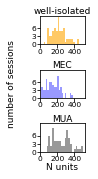

In [11]:
''' fig. 1h '''
gs  = gridspec.GridSpec(3, 1, hspace=0.9)
f = plt.figure(figsize=(0.8, 2.5))

# good units
ax1 = plt.subplot(gs[0])
ax1.hist(N_good, bins=20, color='orange', alpha=0.6)
ax1.set_title('well-isolated',  fontsize=9, pad=2)
ax1.set_xticks([0, 200, 400])
ax1_ylim = ax1.get_ylim()
ax1_xlim = ax1.get_xlim()

# all MEC
ax2 = plt.subplot(gs[1])
ax2.hist(good_MEC, bins=20, color='b', alpha=0.4)
ax2.set_title('MEC', fontsize=9, pad=2)
ax2.set_xticks([0, 200, 400])
ax2_ylim = ax2.get_ylim()
ax2_xlim = ax2.get_xlim()
ax2.set_ylabel('number of sessions', fontsize=9, labelpad=15)

# MUA
ax3 = plt.subplot(gs[2])
ax3.hist(N_MUA, bins=20, color='k', alpha=0.4)
ax3.set_title('MUA',  fontsize=9, pad=2)
ax3.set_xticks([0, 200, 400])
ax3_ylim = ax3.get_ylim()
ax3_xlim = ax3.get_xlim()
ax3.set_xlabel('N units', fontsize=9, labelpad=1)

# set lims
y_max = np.max((ax1_ylim[1], ax2_ylim[1], ax3_ylim[1]))
x_max = np.max((ax1_xlim[1], ax2_xlim[1], ax3_xlim[1]))
ax1.set_ylim([0, y_max])
ax1.set_xlim([0, x_max])
ax1.set_yticks([0, 3, 6])
ax1.tick_params(which='major', labelsize=7.5, pad=0.5)
ax2.set_ylim([0, y_max])
ax2.set_xlim([0, x_max])
ax2.set_yticks([0, 3, 6])
ax2.tick_params(which='major', labelsize=7.5, pad=0.5)
ax3.set_ylim([0, y_max])
ax3.set_xlim([0, x_max])
ax3.set_yticks([0, 3, 6])
ax3.tick_params(which='major', labelsize=7.5, pad=0.5)

f.savefig(save_folder + 'N_recorded_units.png', dpi=400, bbox_inches='tight')
plt.show()

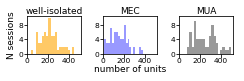

In [68]:
''' fig. 1h '''
gs  = gridspec.GridSpec(1, 3, wspace=0.4)
f = plt.figure(figsize=(3.7, 0.7))

# good units
ax1 = plt.subplot(gs[0])
ax1.hist(N_good, bins=20, color='orange', alpha=0.6)
ax1.set_title('well-isolated',  fontsize=9, pad=2)
ax1.set_xticks([0, 200, 400])
ax1_ylim = ax1.get_ylim()
ax1_xlim = ax1.get_xlim()

# all MEC
ax2 = plt.subplot(gs[1])
ax2.hist(good_MEC, bins=20, color='b', alpha=0.4)
ax2.set_title('MEC', fontsize=9, pad=2)
ax2.set_xticks([0, 200, 400])
ax2_ylim = ax2.get_ylim()
ax2_xlim = ax2.get_xlim()

# MUA
ax3 = plt.subplot(gs[2])
ax3.hist(N_MUA, bins=20, color='k', alpha=0.4)
ax3.set_title('MUA',  fontsize=9, pad=2)
ax3.set_xticks([0, 200, 400])
ax3_ylim = ax3.get_ylim()
ax3_xlim = ax3.get_xlim()

# set lims
y_max = np.max((ax1_ylim[1], ax2_ylim[1], ax3_ylim[1]))
x_max = np.max((ax1_xlim[1], ax2_xlim[1], ax3_xlim[1]))
ax1.set_ylim([0, y_max])
ax1.set_xlim([0, x_max])
ax1.set_yticks([0, 4, 8])
ax1.tick_params(which='major', labelsize=7.5, pad=0.5)
ax2.set_ylim([0, y_max])
ax2.set_xlim([0, x_max])
ax2.set_yticks([0, 4, 8])
ax2.tick_params(which='major', labelsize=7.5, pad=0.5)
ax3.set_ylim([0, y_max])
ax3.set_xlim([0, x_max])
ax3.set_yticks([0, 4, 8])
ax3.tick_params(which='major', labelsize=7.5, pad=0.5)

# label axes
ax1.set_ylabel('N sessions', fontsize=9, labelpad=2)
ax2.set_xlabel('number of units', fontsize=9, labelpad=1)

f.savefig(save_folder + 'N_recorded_units.png', dpi=400, bbox_inches='tight')
plt.show()

In [12]:
cell_coords_ex1 = data['Seattle']['1009_1']['good_coords'].copy()
cell_coords_ex2 = data['Toronto']['1112_1']['good_coords'].copy()

In [13]:
print(np.max(cell_coords_ex1, axis=0))
print(np.min(cell_coords_ex1, axis=0))

[ 128.52758482  628.64884498 2267.25434369]
[ -33.25225932  162.75421461 -586.57703312]


In [19]:
MEC_cell_coords = np.asarray([])
for m, session in zip(mice, sessions):
    for s in session:
        d = data[m][s]
        cell_coords = d['cell_coords']
        if MEC_cell_coords.shape[0] == 0:
            MEC_cell_coords = cell_coords
        else:
            MEC_cell_coords = np.row_stack((MEC_cell_coords, cell_coords))

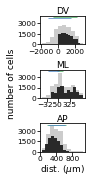

In [20]:
''' plot histograms of DV, ML, and AP coords for each unit, overlay coordinates for MEC cells '''
gs  = gridspec.GridSpec(3, 1, hspace=0.9)
f = plt.figure(figsize=(0.8, 2.5))

# plot DV coords:
ax0 = plt.subplot(gs[0])
ax0.hist(all_good_coords[:, -1], color='k', alpha=0.2)
ax0.hist(MEC_cell_coords[:, -1], color='k', alpha=0.8)
ax0.set_title('DV', fontsize=9, pad=2)

# plot ML coords:
ax1 = plt.subplot(gs[1])
ax1.hist(all_good_coords[:, 0], color='k', alpha=0.2)
ax1.hist(MEC_cell_coords[:, 0], color='k', alpha=0.8)
ax1.set_title('ML', fontsize=9, pad=2)

# plot AP coords:
ax2 = plt.subplot(gs[2])
ax2.hist(all_good_coords[:, 1], color='k', alpha=0.2)
ax2.hist(MEC_cell_coords[:, 1], color='k', alpha=0.8)
ax2.set_title('AP', fontsize=9, pad=2)

# show where example recordings were located
ylim_0 = ax0.get_ylim()
ylim_1 = ax1.get_ylim()
ylim_2 = ax2.get_ylim()
y_max = np.max((ylim_0[1], ylim_1[1], ylim_2[1]))

tip_coords = np.row_stack((np.max(cell_coords_ex1, axis=0), np.max(cell_coords_ex2, axis=0)))
enter_coords = np.row_stack((np.min(cell_coords_ex1, axis=0), np.min(cell_coords_ex2, axis=0)))
ax0.hlines(y_max+100, tip_coords[0, -1], enter_coords[0, -1], 
           colors=colors[mice.index('Seattle')], lw=0.75, linestyles='solid')
ax1.hlines(y_max+100, tip_coords[0, 0], enter_coords[0, 0], 
           colors=colors[mice.index('Seattle')], lw=0.75, linestyles='solid')
ax2.hlines(y_max+100, tip_coords[0, 1], enter_coords[0, 1], 
           colors=colors[mice.index('Seattle')], lw=0.75, linestyles='solid')
ax0.hlines(y_max, tip_coords[1, -1], enter_coords[1, -1], 
           colors=colors[mice.index('Toronto')], lw=0.75, linestyles='solid')
ax1.hlines(y_max, tip_coords[1, 0], enter_coords[1, 0], 
           colors=colors[mice.index('Toronto')], lw=0.75, linestyles='solid')
ax2.hlines(y_max, tip_coords[1, 1], enter_coords[1, 1], 
           colors=colors[mice.index('Toronto')], lw=0.75, linestyles='solid')

ax0.set_xticks([-2000, 0, 2000])
ax0.set_yticks([0, 1500, 3000])
ax0.tick_params(which='major', labelsize=7.5, pad=0.5)
ax0.set_ylim([0, y_max+250])
ax1.set_xticks([-325, 0, 325])
ax1.set_yticks([0, 1500, 3000])
ax1.set_ylim([0, y_max+250])
ax1.tick_params(which='major', labelsize=7.5, pad=0.5)
ax2.set_xticks([0, 400, 800])
ax2.set_yticks([0, 1500, 3000])
ax2.set_ylim([0, y_max+250])
ax2.tick_params(which='major', labelsize=7.5, pad=0.5)

# label axes
ax1.set_ylabel('number of cells', fontsize=9, labelpad=1)
ax2.set_xlabel('dist. ($\mu$m)', fontsize=9, labelpad=1)

f.savefig(save_folder + 'all_anatomical_coordinates.png', dpi=400, bbox_inches='tight')
plt.show()

In [15]:
''' plot example insertions relative to MEC boundaries for sessions from the same hemisphere '''
example_mice = ['Seattle', 'Toronto']
example_sessions = [['1009_1', '1010_1'], ['1112_1', '1113_1', '1111_1']]
example_colors = ['xkcd:vermillion', 'xkcd:sky blue', 'xkcd:gold']

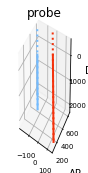

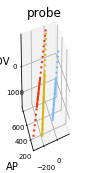

In [16]:
''' fig. 1k '''
from mpl_toolkits.mplot3d import Axes3D

for m, session in zip(example_mice, example_sessions):
    f = plt.figure(figsize=(1.2, 2.8))
    ax = f.add_subplot(111, projection='3d')
    
    for i, s in enumerate(session):
        # get enter and coordinates
        d = data[m][s]
        all_cell_coords = d['good_coords'].copy()
        tip_idx = np.argmax(all_cell_coords, axis=0)[-1]
        tip_coords = all_cell_coords[tip_idx, :]
        enter_idx = np.argmin(all_cell_coords, axis=0)[-1]
        enter_coords = all_cell_coords[enter_idx, :]
        MEC_cell_coords = d['cell_coords'].copy()
        tip_idx = np.argmax(MEC_cell_coords, axis=0)[-1]
        MEC_tip_coords = MEC_cell_coords[tip_idx, :]
        enter_idx = np.argmin(MEC_cell_coords, axis=0)[-1]
        MEC_enter_coords = MEC_cell_coords[enter_idx, :]

        # plot overall probe location
        ax.plot([enter_coords[0], tip_coords[0]], 
                [enter_coords[1], tip_coords[1]], 
                [enter_coords[2], tip_coords[2]], 
                ':', color=example_colors[i], lw=2, zorder=0, alpha=1)

        # plot portion in MEC
        ax.plot([MEC_enter_coords[0], MEC_tip_coords[0]], 
                [MEC_enter_coords[1], MEC_tip_coords[1]], 
                [MEC_enter_coords[2], MEC_tip_coords[2]], 
                '-', color=example_colors[i], lw=2, zorder=1, alpha=1)
        
    ax.set_zlim(ax.get_zlim()[::-1])
    ax.set_zticks([0, 1000, 2000])
#     ax.set_xticks([-150, 0, 150])
#     ax.set_yticks([150, 350])
    ax.tick_params(which='major', labelsize=7, pad=0.5)
#     ax.tick_params(labelright=False, labelbottom=False, labelleft=False)

    ax.set_xlabel('ML')
    ax.set_ylabel('AP')
    ax.set_zlabel('DV')
    ax.set_title('probe')
    if m == 'Seattle':
        ax.view_init(azim=300)
    else:
        ax.view_init(azim=250)

    f.savefig(save_folder + '{}_{}_probe_coords.png'.format(m, s), dpi=400, bbox_inches='tight')
    plt.show()

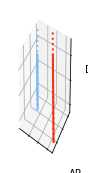

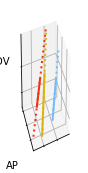

In [17]:
''' fig. 1k '''
from mpl_toolkits.mplot3d import Axes3D

for m, session in zip(example_mice, example_sessions):
    f = plt.figure(figsize=(1.2, 2.8))
    ax = f.add_subplot(111, projection='3d')
    
    for i, s in enumerate(session):
        # get enter and coordinates
        d = data[m][s]
        all_cell_coords = d['good_coords'].copy()
        tip_idx = np.argmax(all_cell_coords, axis=0)[-1]
        tip_coords = all_cell_coords[tip_idx, :]
        enter_idx = np.argmin(all_cell_coords, axis=0)[-1]
        enter_coords = all_cell_coords[enter_idx, :]
        MEC_cell_coords = d['cell_coords'].copy()
        tip_idx = np.argmax(MEC_cell_coords, axis=0)[-1]
        MEC_tip_coords = MEC_cell_coords[tip_idx, :]
        enter_idx = np.argmin(MEC_cell_coords, axis=0)[-1]
        MEC_enter_coords = MEC_cell_coords[enter_idx, :]

        # plot overall probe location
        ax.plot([enter_coords[0], tip_coords[0]], 
                [enter_coords[1], tip_coords[1]], 
                [enter_coords[2], tip_coords[2]], 
                ':', color=example_colors[i], lw=2, zorder=0, alpha=1)

        # plot portion in MEC
        ax.plot([MEC_enter_coords[0], MEC_tip_coords[0]], 
                [MEC_enter_coords[1], MEC_tip_coords[1]], 
                [MEC_enter_coords[2], MEC_tip_coords[2]], 
                '-', color=example_colors[i], lw=2, zorder=1, alpha=1)
        
    ax.set_zlim(ax.get_zlim()[::-1])
    ax.set_zticks([0, 1000, 2000])
#     ax.set_xticks([-150, 0, 150])
#     ax.set_yticks([150, 350])
    ax.tick_params(which='major', labelsize=7, pad=0.5)
    ax.tick_params(labelright=False, labelbottom=False, labelleft=False)

    ax.set_xlabel('ML')
    ax.set_ylabel('AP')
    ax.set_zlabel('DV')
    if m == 'Seattle':
        ax.view_init(azim=300)
    else:
        ax.view_init(azim=250)

    f.savefig(save_folder + '{}_{}_probe_coords_clean.png'.format(m, s), dpi=400, bbox_inches='tight')
    plt.show()

In [25]:
print(tip_coords)
print(MEC_tip_coords)

[  18.50716627  624.13299353 1526.58023595]
[ -65.61332448  440.1209939  1526.58023595]


In [10]:
# calculate similarity score across trials
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform
from dynamic_coding_analysis.analysis_pipeline import process_spikes as spk

for m, session in zip(mice, sessions):
    for s in session:
        d = data[m][s]
        Y = d['Y'].copy()
        Y_unwrapped = np.reshape(Y, (Y.shape[0], -1))
        sim_vec = np.abs(pdist(Y_unwrapped, 'correlation')-1)
        sim = squareform(sim_vec)
        d['similarity'] = sim

In [21]:
# show similarity matrices and 3 (2?) exmaple cells for each session from 6a L hem and 7b L hem
ex_mice = ['Seattle', 'Toronto']
ex_sessions = [['1009_1', '1010_1'], ['1111_1', '1112_1', '1113_1']]
ex_cells = {}
ex_cells['Seattle'] = [[987, 562, 897], [529, 590, 68]]
ex_cells['Toronto'] = [[519, 511, 402], [499, 467, 433], [220, 160, 75]]

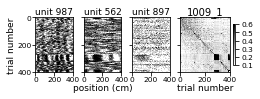

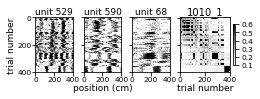

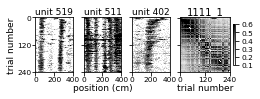

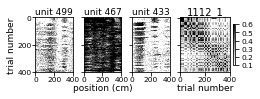

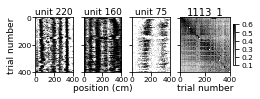

In [30]:
for m, session in zip(ex_mice, ex_sessions):
    for j, s in enumerate(session):
        gs  = gridspec.GridSpec(1, 9, wspace=0.8)
        f = plt.figure(figsize=(3.7, 1))

        cell_IDs = ex_cells[m][j]

        # load data
        d = data[m][s]
        A = d['A']
        B = d['B']
        cells = d['cells']

        # plot example rasters
        ax_start = 0
        for i, cell_ID in enumerate(cell_IDs):
            ax_end = ax_start+2
            sdx = B[:, np.where(cells==cell_ID)[0][0]].astype(bool)
            ax0 = plt.subplot(gs[ax_start:ax_end])

            # plot it
            ax0.scatter(A[:, 0][sdx], A[:, 2][sdx], color='k', lw=0, s=0.2, alpha=.3)
            ax0.set_xlim([0, 400])
            ylim_ax = [0, np.max(A[:, 2])]
            ax0.set_ylim(ylim_ax[::-1])
            trial_num = np.max(A[:, 2]) + 1           
            ax0.set_yticks([0, np.round(trial_num//2, 2), np.round(trial_num, 2)])
            ax0.set_title('unit {}'.format(cell_ID), fontsize=9, pad=3)
            if i == 0:
                ax0.set_ylabel('trial number', fontsize=9, labelpad=1)
            elif i == 1:
                ax0.set_xlabel('position (cm)', fontsize=9, labelpad=1)
                ax0.tick_params(labelleft=False)
            else:
                ax0.tick_params(labelleft=False)
            ax0.set_xticks(np.arange(0, 450, 200))
            ax0.tick_params(which='major', labelsize=7.5, pad=0.5)
            ax_start = ax_end

        # plot Euclidean similarity score
        sim = d['similarity']
        ax1 = plt.subplot(gs[ax_end:])
        im = ax1.imshow(sim, clim=[0.1, 0.6], aspect='auto', cmap='Greys')

        trial_num = sim.shape[0]
        ax1.set_xticks([0, np.round(trial_num//2, 2), np.round(trial_num, 2)])
        ax1.set_yticks([0, np.round(trial_num//2, 2), np.round(trial_num, 2)])
  
        ax1.set_xlabel('trial number', fontsize=9, labelpad=1)
        ax1.tick_params(labelleft=False, which='major', labelsize=7.5, pad=0.5)
        ax1.set_title(s, fontsize=10, pad=3)
        cbar = f.colorbar(im, shrink=0.75)
        cbar.ax.tick_params(labelsize=7.5)

        f.savefig(save_folder + m + '_' + s + '_rasters_similarity.png', dpi=400, bbox_inches='tight')
        plt.show()

In [46]:
# choose example cells for example sessions
example_sessions = ['0424_1', '0502_1', '0615_2', 
                    '0619_2', '0711_2', '0713_2',
                    '1009_1', '1005_2', '1106_1', 
                    '1009_1', '1112_1', '1118_1']
example_cells = [[], [242, 416, 471], [335, 257, 339], 
                 [], [], [875, 124, 67],
                 [987, 562, 897], [], [325, 346, 363], 
                 [515, 266, 315], [499, 467, 433], [190, 220, 247]]

for i, m in enumerate(mice[:-5]):
    if len(example_cells[i]) > 0:
        continue
    d = data[m][example_sessions[i]]
    cells = d['cells']
    n_cells = cells.shape[0]
    thirds = [n_cells//3, 2*(n_cells//3)]
    
    # choose 3 random cells spaced along DV axis
    cell_1 = np.random.choice(cells[:thirds[0]])
    cell_2 = np.random.choice(cells[thirds[0]:thirds[1]])
    cell_3 = np.random.choice(cells[thirds[1]:])
    example_cells[i] = [cell_1, cell_2, cell_3]

In [47]:
example_cells

[[117, 203, 255],
 [242, 416, 471],
 [335, 257, 339],
 [644, 327, 421],
 [138, 235, 294],
 [875, 124, 67],
 [987, 562, 897],
 [52, 127, 568],
 [325, 346, 363],
 [515, 266, 315],
 [499, 467, 433],
 [190, 220, 247]]

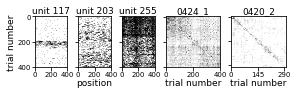

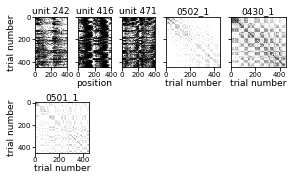

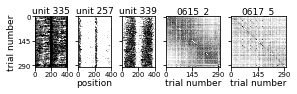

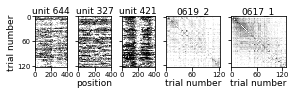

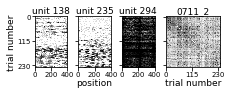

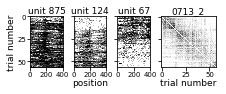

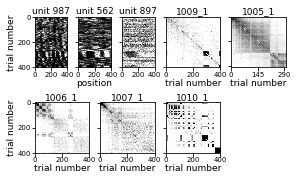

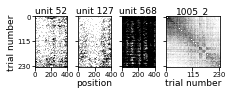

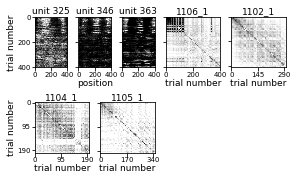

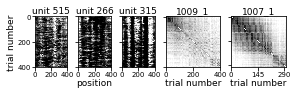

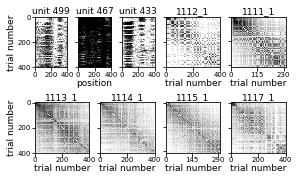

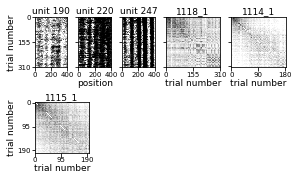

In [48]:
'''
plot 3 (5?) example rasters and similarity matrix for one session from each mouse
plot similarity matrices for remaining sessions
cue rich or poor only -- will probably have a separate figure for 2 track mice
'''
for i, m in enumerate(mice[:-5]):
    session = sessions[i]
    ex_session = example_sessions[i]
    n_sessions = len(session)
    
    # each similarity matrix is 3 subplots wide, each raster is 2 wide
    gs  = gridspec.GridSpec(2, 12, hspace=0.7, wspace=1)
    f = plt.figure(figsize=(4.5, 2.5))
    j = 9
    k = 0

    for s in session:
        d = data[m][s]
        A = d['A']

        # plot example cells for just one session
        if s == ex_session:
            cell_IDs = example_cells[mice.index(m)]    
            B = d['B']
            cells = d['cells']

            # plot example rasters
            ax_start = 0
            for i, cell_ID in enumerate(cell_IDs):
                ax_end = ax_start+2
                sdx = B[:, np.where(cells==cell_ID)[0][0]].astype(bool)
                ax0 = plt.subplot(gs[0, ax_start:ax_end])

                # plot it
                if m=='Calais':
                    ax0.scatter(A[:, 0][sdx], A[:, 2][sdx], color='k', lw=0, s=0.6, alpha=.3)                    
                else:
                    ax0.scatter(A[:, 0][sdx], A[:, 2][sdx], color='k', lw=0, s=0.3, alpha=.3)
                ax0.set_xlim([0, 400])
                ylim_ax = [0, np.max(A[:, 2])]
                ax0.set_ylim(ylim_ax[::-1])
                ax0.set_title("unit {}".format(cell_ID), fontsize=9, pad=3)
                ax_start = ax_end

                # label axes
                if np.max(A[:, 2]) >= 399:
                    ax0.set_yticks([0, 200, 400])
                else:
                    ax0.set_yticks([0, np.round(np.max(A[:, 2]-5), -1)//2, np.round(np.max(A[:, 2]-5), -1)])
                ax0.set_xticks(np.arange(0, 450, 200))
                if i==0:
                    ax0.set_ylabel('trial number', fontsize=9, labelpad=1)
                    ax0.tick_params(which='major', labelsize=7, pad=0.5)
                elif i==1:
                    ax0.set_xlabel('position', fontsize=9, labelpad=1)
                    ax0.tick_params(labelleft=False, which='major', labelsize=7, pad=0.5)
                else:
                    ax0.tick_params(labelleft=False, which='major', labelsize=7, pad=0.5)
            ax1 = plt.subplot(gs[0, ax_end:9])
            ax1.tick_params(labelleft=False, which='major', labelsize=7, pad=0.5)
        else:
            if j >= 12:
                k += 1
                j = 0
            ax1 = plt.subplot(gs[k, j:j+3])
            j += 3
            if (k==1) & (j==3):
                ax1.set_ylabel('trial number', fontsize=9, labelpad=1)
                ax1.tick_params(which='major', labelsize=7, pad=0.5)
            else:
                ax1.tick_params(labelleft=False, which='major', labelsize=7, pad=0.5)

        # plot Euclidean similarity score
        sim = d['similarity']
        im = ax1.imshow(sim, clim=[0.2, 0.7], aspect='auto', cmap='Greys')
        ax1.set_title(s, fontsize=9, pad=3)  
        ax1.set_xlabel('trial number', fontsize=9, labelpad=1)  
        if np.max(A[:, 2]) >= 399:
                ax1.set_yticks([0, 200, 400])
                ax1.set_xticks([0, 200, 400])
        else:
            ax1.set_yticks([0, np.round(np.max(A[:, 2]-5), -1)//2, np.round(np.max(A[:, 2]-5), -1)])
            ax1.set_xticks([0, np.round(np.max(A[:, 2]-5), -1)//2, np.round(np.max(A[:, 2]-5), -1)])

    f.savefig(save_folder + m + '_rasters_similarity.png', dpi=400, bbox_inches='tight')
    plt.show()

In [82]:
m = 'Seattle'
ex_session = '1009_1'
# m = 'Toronto'
# ex_session = '1112_1'

session = sessions[mice.index(m)]
cell_IDs = example_cells[mice.index(m)]

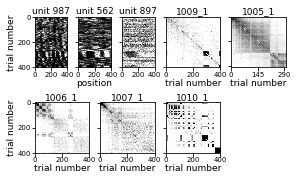

In [83]:
'''
examples for fig. S1
'''
# each similarity matrix is 3 subplots wide, each raster is 2 wide
gs  = gridspec.GridSpec(2, 12, hspace=0.7, wspace=1)
f = plt.figure(figsize=(4.5, 2.5))
j = 9
k = 0

for s in session:
    d = data[m][s]
    A = d['A']

    # plot example cells for just one session
    if s == ex_session:
        B = d['B']
        cells = d['cells']

        # plot example rasters
        ax_start = 0
        for i, cell_ID in enumerate(cell_IDs):
            ax_end = ax_start+2
            sdx = B[:, np.where(cells==cell_ID)[0][0]].astype(bool)
            ax0 = plt.subplot(gs[0, ax_start:ax_end])

            # plot it
            ax0.scatter(A[:, 0][sdx], A[:, 2][sdx], color='k', lw=0, s=0.3, alpha=.3)
            ax0.set_xlim([0, 400])
            ylim_ax = [0, np.max(A[:, 2])]
            ax0.set_ylim(ylim_ax[::-1])
            ax0.set_title("unit {}".format(cell_ID), fontsize=9, pad=3)
            ax_start = ax_end

            # label y-axes
            ax0.set_yticks([0, 200, 400])
            ax0.set_xticks(np.arange(0, 450, 200))
            if i==0:
                ax0.set_ylabel('trial number', fontsize=9, labelpad=1)
                ax0.tick_params(which='major', labelsize=7, pad=0.5)
            elif i==1:
                ax0.set_xlabel('position', fontsize=9, labelpad=1)
                ax0.tick_params(labelleft=False, which='major', labelsize=7, pad=0.5)
            else:
                ax0.tick_params(labelleft=False, which='major', labelsize=7, pad=0.5)
        ax1 = plt.subplot(gs[0, ax_end:9])
    else:
        if j >= 12:
            k += 1
            j = 0
        ax1 = plt.subplot(gs[k, j:j+3])
        j += 3

    # plot Euclidean similarity score
    sim = d['similarity']
    im = ax1.imshow(sim, clim=[0.2, 0.7], aspect='auto', cmap='Greys')
    ax1.set_xlabel('trial number', fontsize=9, labelpad=1)
    if (k==1) & (j==3):
        ax1.set_ylabel('trial number', fontsize=9, labelpad=1)
        ax1.tick_params(which='major', labelsize=7, pad=0.5)
    else:
        ax1.tick_params(labelleft=False, which='major', labelsize=7, pad=0.5)
    ax1.set_title(s, fontsize=9, pad=3)    
    if np.max(A[:, 2]) >= 399:
            ax1.set_yticks([0, 200, 400])
            ax1.set_xticks([0, 200, 400])
    else:
        ax1.set_yticks([0, np.round(np.max(A[:, 2]-5), -1)//2, np.round(np.max(A[:, 2]-5), -1)])
        ax1.set_xticks([0, np.round(np.max(A[:, 2]-5), -1)//2, np.round(np.max(A[:, 2]-5), -1)])

f.savefig(save_folder + m + '_rasters_similarity.png', dpi=400, bbox_inches='tight')
plt.show()

In [31]:
''' look at non-MEC cells for Toronto 1112 '''
m = 'Toronto'
s = '1112_1'
d = data[m][s]

In [32]:
sp = d['sp']
cgs = sp['cgs'].copy()
cids = sp['cids'].copy()
cluster_id = sp['clu'].copy()
spiket = sp['st'].copy()
good_cells = cids[cgs == 2]
MEC_cells = d['cells']
non_MEC_cells = np.setdiff1d(good_cells, MEC_cells)

In [33]:
folder = base + m + '/'
data_file = m + '_' + s + '_data.mat'
behave_data = get_data.loadData(folder + data_file)

G:/My Drive/Giocomo Lab/RandomForage/Toronto/Toronto_1112_1_data.mat
dict_keys(['sp', 'post', 'posx', 'lickt', 'trial', 'reward', 'framet', 'pupil', 'whisk', 'pupil_upsampled', 'whisk_upsampled', 'testvid_start'])


In [34]:
''' construct B for non-MEC cells '''
# get behavioral params
posx = behave_data['posx']
post = behave_data['post']
trial = get_data.trial_idx(posx)
dt = np.unique(np.round(np.diff(post),4))
speed = get_data.getSpeed(posx, dt)

# format spike and behavioral data
A = np.column_stack((posx, speed, trial, post))
B = np.zeros((A.shape[0], non_MEC_cells.shape[0]))
print('spike matrix size pre behavioral filtering = ' + str(B.shape))

for i in trange(non_MEC_cells.shape[0]):
    # get spike times
    st = spiket[cluster_id == non_MEC_cells[i]]
    B[:, i] = get_data.spiketrain(post, dt, st)

# filter by speed
def find(x):
    return x.nonzero()[0]
speed_to_trash = find(speed < 2)
keep_idx = np.setdiff1d(np.arange(A.shape[0]), speed_to_trash)
A = A[keep_idx, :]
B = B[keep_idx, :]

# correct track ends
neg_pos = find(A[:, 0] < 0)
A[neg_pos, 0] = A[neg_pos, 0] + 400
plus_pos = find(A[:, 0] >= 400)
A[plus_pos, 0] = A[plus_pos, 0] - 400

# filter by spikes
non_MEC_cells = non_MEC_cells[np.sum(B, axis=0) > 400]
B = B[:, np.sum(B, axis=0) > 400]

C:\Users\ilow1\Documents\Python Scripts\dynamic_coding_analysis\analysis_pipeline\get_data.py:232: RuntimeWarning: invalid value encountered in less
  speed[speed < -5] = np.nan


spike matrix size pre behavioral filtering = (348943, 139)


100%|██████████████████| 139/139 [00:03<00:00, 41.95it/s]


In [35]:
# get Y for non-MEC cells
Y, centers = spk.tuning_curve_bytrial(A[:, 0], A[:, 2], B, dt, 5, smooth=True, normalize=False)
Y[np.isnan(Y)] = 0.0

# normalize and clip at 90th percentile
for n in range(Y.shape[-1]):
    Yn = Y[:, :, n]
    Y[:, :, n] = np.clip(Yn, 0, np.percentile(Yn[Yn > 0], 90))
Y = Y - np.min(Y, axis=(0, 1), keepdims=True)
Y = Y / np.max(Y, axis=(0, 1), keepdims=True)
Y = Y[:, :, np.all(np.isfinite(Y), axis=(0, 1))]

In [36]:
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform

# calculate similarity
Y_unwrapped = np.reshape(Y, (Y.shape[0], -1))
sim_vec = np.abs(pdist(Y_unwrapped, 'correlation')-1)
sim = squareform(sim_vec)

In [37]:
cell_IDs = [228, 271, 292]

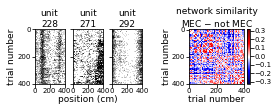

In [42]:
gs  = gridspec.GridSpec(1, 12, wspace=0.8)
f = plt.figure(figsize=(4, 1))

# plot example rasters
ax_start = 0
for i, cell_ID in enumerate(cell_IDs):
    ax_end = ax_start+2
    sdx = B[:, np.where(non_MEC_cells==cell_ID)[0][0]].astype(bool)
    ax0 = plt.subplot(gs[ax_start:ax_end])

    # plot it
    ax0.scatter(A[:, 0][sdx], A[:, 2][sdx], color='k', lw=0, s=0.3, alpha=.3)
    ax0.set_xlim([0, 400])
    ylim_ax = [0, np.max(A[:, 2])]
    ax0.set_ylim(ylim_ax[::-1])
    ax0.set_yticks([0, 200, 400])

    if i==0:
        ax0.set_ylabel('trial number', fontsize=9, labelpad=1)
    else:
        ax0.tick_params(labelleft=False)
    ax0.set_title('unit\n{}'.format(cell_ID), fontsize=9, pad=3)
    ax0.set_xticks(np.arange(0, 450, 200))
    ax0.tick_params(which='major', labelsize=7, pad=0.5)
    if i == 1:
        ax0.set_xlabel('position (cm)', fontsize=9, labelpad=1)
    ax_start = ax_end

# plot Euclidean similarity score
ax1 = plt.subplot(gs[ax_end+2:])
im = ax1.imshow(d['similarity']-sim, aspect='auto', cmap='seismic')
ax1.set_xticks([0, 200, 400])
ax1.set_yticks([0, 200, 400])
ax1.tick_params(which='major', labelsize=7, pad=0.5)
ax1.set_xlabel('trial number', fontsize=9, labelpad=1)
ax1.set_ylabel('trial number', fontsize=9, labelpad=1)
ax1.set_title('network similarity\nMEC $-$ not MEC', fontsize=9, pad=3)
cbar = f.colorbar(im)
cbar.ax.tick_params(labelsize=7, pad=0.5)

f.savefig(save_folder + m + '_' + s + '_nonMEC_rasters_similarity.png', dpi=400, bbox_inches='tight')
plt.show()